### • Median Consensus

Suppose the sensor network now aims to compute the **median** of the measurement data.

- Implement the **median consensus problem** using the **PDMM algorithm**.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib as mpl
from matplotlib.animation import PillowWriter
from IPython.display import Image
from helper import min_radius_for_sensors

Minimum required radius for connectivity with probability: 99.96000000000001 (n=50, area=100x100): 39.56 m


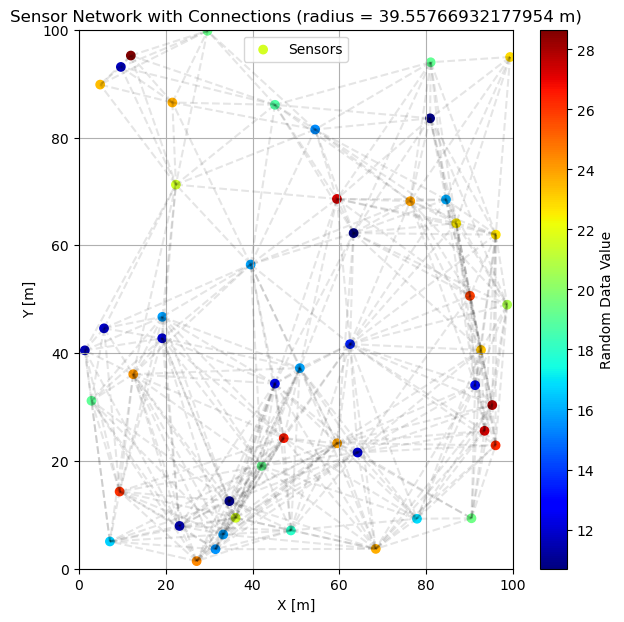

In [3]:
# Parameters
NUM_SENSORS = 50
AREA_WIDTH = 100  # meters
DIMENSION = 2

# Ensure all sensors are connected with the desired radius
radius = min_radius_for_sensors(NUM_SENSORS, DIMENSION, AREA_WIDTH)

# Generate random sensor positions again for the augmented plot
coords = np.random.uniform(low = 0, high = AREA_WIDTH, size = (NUM_SENSORS, DIMENSION))

# coords has shape (N, 2)
random_column = np.random.uniform(low=10, high=30, size=(coords.shape[0], 1))  # shape (N, 1)

# concatenate along axis=1 (columns)
coords_augmented = np.hstack((coords, random_column))  # shape (N, DIMENSION + 1)

# Compute pairwise distances
dists = np.sqrt(np.sum((coords_augmented[:, None, 0:2] - coords_augmented[None, :, 0:2])**2, axis=-1))

adjacency = (dists <= radius) & (dists > 0)

# Create figure
plt.figure(figsize=(7, 7))

# Scatter plot with color based on random data
sc = plt.scatter(x = coords[:,0], y = coords[:,1], c=coords_augmented[:,2].flatten(), cmap='jet', label='Sensors')

# Draw dashed black lines for connected sensors
for i in range(NUM_SENSORS):
    neighbors = np.where(adjacency[i])[0]
    for j in neighbors:
        if i < j:  # Avoid duplicates
            plt.plot([coords[i, 0], coords[j, 0]],
                     [coords[i, 1], coords[j, 1]],
                     'k--', alpha=0.1)

# Add colorbar
cbar = plt.colorbar(sc)
cbar.set_label('Random Data Value')

# Final plot settings
plt.xlim(0, AREA_WIDTH)
plt.ylim(0, AREA_WIDTH)
plt.title(f'Sensor Network with Connections (radius = {radius} m)')
plt.xlabel('X [m]')
plt.ylabel('Y [m]')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
def median_consensus(adjacency, values, num_iters=100, c=1.0, verbose=False):
    """
    Median consensus via PDMM using L1-norm minimization.

    Parameters:
        adjacency: (N, N) boolean adjacency matrix
        values: (N,) array of private scalar values (si)
        num_iters: number of iterations
        c: convergence parameter
        verbose: whether to print diagnostics

    Returns:
        history: list of node values over time
    """
    N = len(values)
    s = values.copy()
    x = np.zeros_like(s)
    history = [x.copy()]
    degrees = np.sum(adjacency, axis=1)

    if np.any(degrees == 0):
        raise ValueError("Some nodes have no neighbors; graph must be connected.")

    # A_ij = +1 if i < j, -1 if i > j
    def A(i, j): return 1.0 if i < j else -1.0

    z = {}
    for i in range(N):
        for j in np.where(adjacency[i])[0]:
            if (i, j) not in z:
                z[(i, j)] = np.random.normal(loc=A(i, j), scale=0.1)
                z[(j, i)] = -z[(i, j)]

    for t in range(num_iters):
        x_new = np.zeros_like(x)

        # x update
        for i in range(N):
            neighbors = np.where(adjacency[i])[0]
            zsum = sum(A(i, j) * z[(i, j)] for j in neighbors)
            candidate = -1 - zsum / (c * degrees[i])
            if candidate > s[i]:
                x_new[i] = candidate
            else:
                candidate = 1 - zsum / (c * degrees[i])
                if candidate < s[i]:
                    x_new[i] = candidate
                else:
                    x_new[i] = s[i]

        # z update
        for i in range(N):
            for j in np.where(adjacency[i])[0]:
                z[(j, i)] = 0.5 * z[(j, i)] + 0.5 * (z[(i, j)] + 2 * c * A(i, j) * x_new[i])

        x = x_new.copy()
        history.append(x.copy())

        if verbose and t % 10 == 0:
            med_error = np.max(np.abs(x - np.median(s)))
            print(f"Iter {t}: max deviation from median = {med_error:.6f}")

    return x, np.median(s), history


Iter 0: max deviation from median = 19.246237
Iter 10: max deviation from median = 11.831439
Iter 20: max deviation from median = 6.117444
Iter 30: max deviation from median = 3.004610
Iter 40: max deviation from median = 1.471923
Iter 50: max deviation from median = 0.854252
Iter 60: max deviation from median = 0.374751
Iter 70: max deviation from median = 0.175598
Iter 80: max deviation from median = 0.112888
Iter 90: max deviation from median = 0.135848


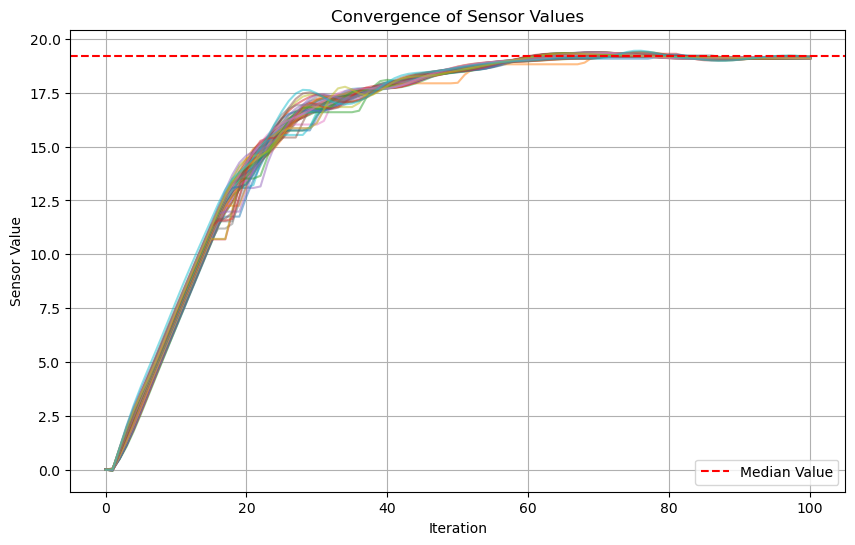

In [ ]:
#from pdmm_median_consensus import median_consensus

# Run median consensus algorithm
final_values, median_value, history = median_consensus(adjacency, coords_augmented[:, 2], num_iters=100, c=1.0, verbose=False)

# Plot convergence of values
plt.figure(figsize=(10, 6))
plt.plot(history, alpha=0.5)
plt.title('Convergence of Sensor Values')
plt.xlabel('Iteration')
plt.ylabel('Sensor Value')
plt.axhline(median_value, color='red', linestyle='--', label='Median Value')
plt.legend()
plt.grid(True)
plt.show()